# Handwriting Recognition - USPS Post Dataset

## Problem:

This project introduces us to a major topic in Supervised Machine Learning, which is __Classification__. We shall be studying the multiclass classification problem, by applying supervised classification algorithms on two datasets provided:

    1. MNIST Dataset

    2. USPS Dataset
    
In particular, we shall be applying the following algorithms for the task of __Handwritten Character Recognition__:
        1. Logistic Regression
    
        2. Single layered Neural Networks
    
        3. Convolutional Neural Networks
    
This is one of the standard problem in Machine Learning field, and many new algorithms are often compared by their output on this task.


While solving the problem of Handwriting Recognition, we shall encounter the __NO FREE LUNCH THEOREM__. Our objective is to verify that this theorem holds even in this case, as we shall see in subsequent sections.


## Dataset:

    1. We have been provided with the MNIST handwritten digits dataset, 
    which consists of 70000 grayscale images, representing 10 digits - 
    0 to 9. The images are each of 28 x 28 pixel resolution.

    2. We shall be using the MNIST dataset for training our machine 
    learning models.
    
    3. The other dataset is the USPS Dataset. It consists of approximately 
    20000 pixels, which are at resolution of 100ppi. We need to preprocess 
    these images to have same resolution as our MNIST data images, so that 
    our trained models can be applied on this dataset.
    
## Solution:

First we begin by training 3 Machine learning algorithms on the MNIST dataset. Then we shall use these trained models for predicting labels of images in USPS Dataset.

Let us begin by first importing the MNIST Dataset, and preprocessing them in required output format for training our algorithms.

In [1]:
%matplotlib inline
import numpy as np
import cPickle as pickle
import math
import matplotlib.pyplot as plt
import cv2
import os

Let us begin by importing the MNIST dataset, which is stored in a pickle file. We shall import each image which is 28 x 28 pixel matrices, and we shall flatten them out to a 1 x 784 dimension vector.

### Split the MNIST Dataset

We shall also split the dataset into __Train, validation and test data__. We shall have the following split for the data:
    1. Train set -  50000 images
    2. Validation set - 10000 images
    3. Test set - 10000 images

In [2]:
pickle_file = 'mnist.pkl'
image_size = 28
num_labels = 10

def reformat(labels):
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return labels


with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save[0][0]
    train_labels = reformat(save[0][1])
    raw_train_labels = save[0][1]
    valid_dataset = save[1][0]
    valid_labels = reformat(save[1][1])
    raw_valid_labels = save[1][1]
    test_dataset = save[2][0]
    test_labels = reformat(save[2][1])
    raw_test_labels = save[2][1]

In [3]:
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (50000, 784), (50000, 10))
('Validation set', (10000, 784), (10000, 10))
('Test set', (10000, 784), (10000, 10))


### Logistic Regression

Let us train our first machine learning model, which is the multiclass logistic regression. The model parameters are as follows:

    1. Input: 784 element vector, representing a flattened image.
    
    2. We add a 1 to the vector, to handle the bias term. 
    Hence our input vector consists of 785 elements.
    
    3. The output is a 10 dimensional 'one-hot encoded' vector, 
    representing a single digit output.
    
    4. We shall be using batch gradient descent, to speed up 
    the training process,and converge the algorithm faster.
    
    5. We shall be using the Cross Entropy Cost function for 
    optimising our model weights.
    
    6. Since, the problem is actually a classification problem,
    a Softmax layer is added after the regression output, to convert 
    the output values into class probabilities.
    
The logistic classification model can be represented as:

    a[i] = Softmax(W*x[i] + b)

    y[i] = exp(a[i])/sum(a[k])
    
    where x[i] is ith training sample and y[i] is the 
    predicted output vector corresponding of ith example.

In [4]:
def accuracy(y, t):
    count = 0
    for i in range(len(y)):
        if y[i] == t[i]:
            count += 1
    return float(count)/len(y)

def one_hot_encoding(t):
    return np.argmax(t, axis=1)

In [5]:
def plot_data(y_values1, label, axis_dim, xlabel, ylabel, title):
    plt.plot(y_values1, 'b-',label=label)
    plt.axis(axis_dim)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    l = plt.legend()
    plt.show()

In [6]:
def add_ones(X):
    return np.hstack((np.zeros(shape=(X.shape[0],1), dtype='float') + 1, X))

def calculate_entropy_loss(X, w, y):
    loss = 0
    t = np.dot(X, w)
    for i in range(len(t)):
        loss += -1 * np.dot(y[i], np.log(t[i].T))
    return float(loss)/len(t)

def softmax(t):
    prob_matrix = []
    for i in range(len(t)):
        prob_vector = []
        sum_exp = 0
        for j in t[i]:
            sum_exp += np.exp(j)
        for k in t[i]:
            prob_vector.append(float(np.exp(k))/sum_exp)
        prob_matrix.append(prob_vector)
    return np.array(prob_matrix)
            
def get_probabilities(X, theta):
    t = np.dot(X, theta)
    prob_vector = softmax(t)
    return prob_vector

def train_log_regression(X, y):
    X = add_ones(X) # Bias term
    maxiter = 100
    batch_size = 20
    n = X.shape[1] 
    m = X.shape[0]
    theta = np.random.rand(n, len(y[0])) # Initialise random weights
    lmbda = 0.01
    alpha = 0.01
    max_error = 0.1
    loss = 10
    err_iteration = []
    train_accuracy = []
    validation_accuracy = []
    print "num_iter | Loss"
    for iteration in xrange(maxiter):
        start = 0
        for i in range(m/batch_size):
            out_probs = get_probabilities(
                X[start:start+batch_size], theta)
            grad = (1.0/batch_size) * np.dot(
                X[start:start+batch_size].T,
                (out_probs - y[start:start+batch_size]))
            g0 = grad[0]
            grad += ((lmbda * theta) / batch_size)
            grad[0] = g0 
            theta -= alpha * grad

            # calculate the magnitude of the gradient and check for convergence
            loss = calculate_entropy_loss(
                X[start:start+batch_size], theta, y)
            start += batch_size
        err_iteration.append(loss)
        pred_output_train = np.dot(X, theta)
        train_accuracy.append(
            accuracy(raw_train_labels,
                     one_hot_encoding(pred_output_train)))
        pred_output_valid = np.dot(add_ones(valid_dataset), theta)
        validation_accuracy.append(accuracy(
                raw_valid_labels, one_hot_encoding(pred_output_valid)))
        if np.abs(loss)< max_error or math.isnan(loss):
            break
    return theta, err_iteration, train_accuracy, validation_accuracy

In [12]:
weights, err_iteration, train_accuracy, 
    validation_accuracy = train_log_regression(train_dataset, train_labels)

num_iter | Loss


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log


Now that we have trained our logistic regression model, let us view how the model training has improved over iterations of our training.

### Decreasing Loss as Model Trains 

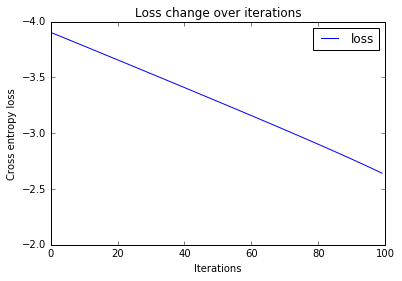

In [24]:
plot_data(err_iteration, 'loss', [0, 100, -2, -4], 'Iterations', 
          'Cross entropy loss', 'Loss change over iterations')

### Increasing Accuracy of Model over Training Data

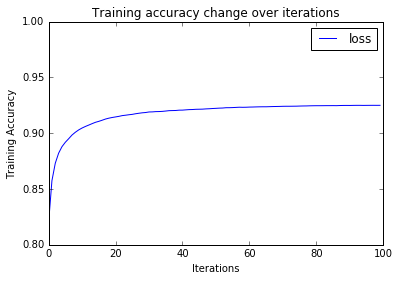

In [26]:
plot_data(train_accuracy, 'loss', [0, 100, 0.8, 1], 'Iterations', 
          'Training Accuracy', 
          'Training accuracy change over iterations')

### Increasing Accuracy of Model over Validation Data

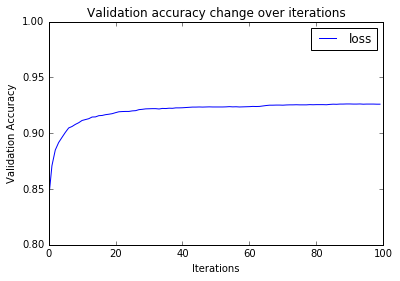

In [27]:
plot_data(validation_accuracy, 'loss', [0, 100, 0.8, 1], 
          'Iterations', 'Validation Accuracy', 
          'Validation accuracy change over iterations')

As we can see, as the model trains over increasing number of iterations over the training data:

    1. Cross Entropy Loss Decreases per iteration
    
    2. Training Accuracy keeps increasing rapidly at beginning, 
    but tends to saturate as number of iterations increase. 
    We shall allow maximum of 100 iterations to prevent overfitting.
    
    3. Validation accuracy also increases as the model trains over 
    repeated iterations.
    
Now that we have trained our model successfully, let us report the results. __The model accuracy that is to be reported is the accuracy over test data.__ 

But first, let us calculate the final train accuracy and validation set accuracy.

In [31]:
pred_output_train = np.dot(add_ones(train_dataset), weights)
print "Training Set Accuracy: ", accuracy(raw_train_labels, 
one_hot_encoding(pred_output_train))

Training Set Accuracy:  0.92498


In [32]:
pred_output_valid = np.dot(add_ones(valid_dataset), weights)
print "Validation Set Accuracy: ", accuracy(raw_valid_labels, 
one_hot_encoding(pred_output_valid))

Validation Set Accuracy:  0.926


In [13]:
pred_output_test = np.dot(add_ones(test_dataset), weights)
print accuracy(raw_test_labels, one_hot_encoding(pred_output_test))

0.9225


#### The accuracy of our LOGISTIC REGRESSION classifier on test MNIST data is 0.9225 or 92.25 %.

Now let us move on to train our next algorithm.

## Single Layer Neural Network

Next we shall be using a Neural network with one single layer, for attempting to classify the handwritten digits. We shall use the same MNIST dataset, which we split into train-validation-test for training and testing purpose. 

Here are the Neural Network parameters used:

    1. Input Layer - 784 neurons
    
    2. Hidden Layer - 500 neurons
    
    3. Output Layer - 10 neurons
    
    4. Batch size for Stochastic Gradient descent - 100
    
    5. Number of training iterations - 5
    
    6. Gradient Descent Learning rate - 0.5
    
We shall initialise the weights between the input layer and hidden layer; and hidden layer and output layer randomly(normal) using a standard deviation of 0.2

In [13]:
train_size=50000
test_size=10000
features=784
k=10
hidden_layer = 500
neural_neta = 0.5
neural_b_size = 100
neural_b_start = 1
neural_iterations = 5
hidden_wts = np.random.normal(0, 0.2, (hidden_layer, features))
neural_out_wts = np.random.normal(0, 0.2,(k, hidden_layer))
hidden_wts = hidden_wts/len(hidden_wts[1])
neural_out_wts = neural_out_wts/len(neural_out_wts[1])
n = np.zeros(neural_b_size)
targetValues= train_labels.T
validation_accuracy = []
train_losses = []
num_iter=0
while(num_iter < neural_iterations):
    neural_b_stop = min(train_size,neural_b_start+neural_b_size-1);
    curr_train_design_mat = train_dataset[
        neural_b_start:neural_b_stop]
    curr_train_output_k_format = train_labels[
        neural_b_start:neural_b_stop]
    curr_train_size = len(curr_train_design_mat)
    for j in range(0,neural_b_size-1):
        train_line = curr_train_design_mat[j]
        hidden_inp = np.dot(hidden_wts,train_line)
        hidden_out = 1/(1 + np.exp(-1 * hidden_inp));
        second_inp = np.dot(neural_out_wts,hidden_out)
        neural_out_line = 1/(1 + np.exp(-1 * second_inp))

        train_out_line = curr_train_output_k_format[j]
        
        second_err = np.multiply(
            np.multiply(neural_out_line,(1 - neural_out_line)),
                                 (neural_out_line - train_out_line))
        hidden_err = np.multiply(
            np.multiply(hidden_out,(1 - hidden_out)),
            np.dot(neural_out_wts.T,second_err))
        neural_out_wts = neural_out_wts - 
            neural_neta * np.dot(np.vstack(second_err),
                                 np.vstack(hidden_out).T)
        hidden_wts = hidden_wts - 
            neural_neta * np.dot(np.vstack(hidden_err),
                                 np.vstack(train_line).T)
    train_losses.append(np.sum(neural_out_line - train_out_line))    
    neural_b_start = neural_b_start+neural_b_size
    if(neural_b_start>train_size):
        print num_iter
        trained_val=np.zeros(len(valid_dataset))
        test_input = valid_dataset
        test_pred = []
        for i in range(len(test_input)):
            test_inp_line = test_input[i]
            hidden_inp = np.dot(hidden_wts, test_inp_line)
            hidden_out = 1/(1 + np.exp(-1 * hidden_inp))
            second_inp = np.dot(neural_out_wts,hidden_out)
            neural_out_line = 1/(1 + np.exp(-1 * second_inp))
            test_pred.append(neural_out_line)
        print "Validation accuracy: ",accuracy(
            raw_valid_labels, one_hot_encoding(np.array(test_pred)))
        validation_accuracy.append(
            accuracy(raw_valid_labels, one_hot_encoding(np.array(test_pred))))
        neural_b_start = 1
        num_iter = num_iter+1

0
Validation accuracy:  0.9526
1
Validation accuracy:  0.961
2
Validation accuracy:  0.9693
3
Validation accuracy:  0.9704
4
Validation accuracy:  0.9738


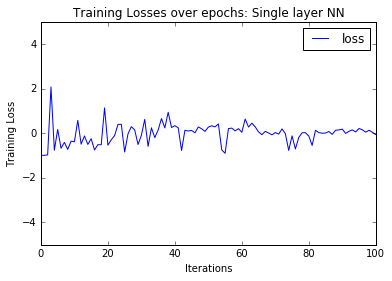

In [42]:
plot_data(train_losses, 'loss', [0, 100, -5, 5], 
          'Iterations', 'Training Loss', 
          'Training Losses over epochs: Single layer NN')

As we are using batch gradient descent, there are a lot of fluctuations in the training losses, which increase every time model encounters a new batch of data, but over many epochs the effective losses decrease and go down to zero as expected.

Let us visualise, the increase in validation accuracy over 5 iterations of the model over train data.

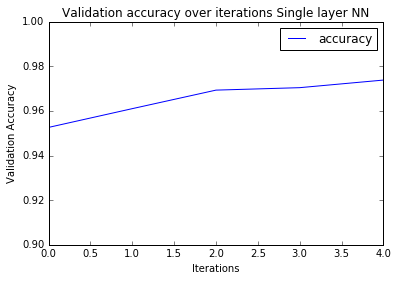

In [16]:
plot_data(validation_accuracy, 'accuracy', [0, 4, 0.9, 1],
          'Iterations', 'Validation Accuracy', 
          'Validation accuracy over iterations Single layer NN')

In [10]:
test_pred = []
for i in range(len(test_dataset)):
    test_inp_line = test_dataset[i]
    hidden_inp = np.dot(hidden_wts, test_inp_line)
    hidden_out = 1/(1 + np.exp(-1 * hidden_inp))
    second_inp = np.dot(neural_out_wts,hidden_out)
    neural_out_line = 1/(1 + np.exp(-1 * second_inp))
    test_pred.append(neural_out_line)
print "Model accuracy: ",accuracy(
    raw_test_labels,one_hot_encoding(np.array(test_pred)))

Model accuracy:  0.9709


As we can see, the improvements of classification on the test set are massive after using a single layer neural network. We got an accuracy of __97.1%__ on the test dataset reserved from the MNIST dataset.

Before we start with the __Convolutional Neural Network__, we are going to preprocess the USPS Dataset. 
After preprocessing the dataset, to have similar format as the MNIST dataset (since we have trained our models on this dataset), we are going to try and predict the accuracy of the __Logistic Regression__ model and the __Single Layer Neural Network__ model on the __USPS Datset__.

This dataset has been completely hidden/unknown for our trained models, and having studied the __No Free Lunch Theorem__, we can expect a massive drop in the prediction accuracies.

Before moving on to the USPS Dataset though, I would like to comment on the __'No Free Lunch Theorem'__

## No Free Lunch (NFL) Theorem

A model is a simplified representation of reality, and the simplifications are made to discard unnecessary detail and allow us to focus on the aspect of reality that we want to understand.  These simplifications are grounded on assumptions; these assumptions may hold in some situations, but may not hold in other situations.  This implies that a model that explains a certain situation well may fail in another situation.

The __“No Free Lunch”__ theorem states that there is __no one model that works best for every problem.__  

The assumptions of a great model for one problem may not hold for another problem, so it is common in machine learning to try multiple models and find one that works best for a particular problem.  

This is __especially true in supervised learning__ problem, which we are trying to solve in this project.

__Validation__ or __Cross-Validation__ is commonly used to assess the predictive accuracies of multiple models of varying complexity to find the best model.

With an understanding of the theorem, let us move to the next section, in which we shall be able to verify it.

## USPS Data 

### Data Processing

So the USPS Dataset comprises of about 20000 images, which have a pixel resolution of 100ppi. But as we have trained the models on the MNIST dataset, the models expect a 784-dimensional feature vector as an input.

Moreover, the pixels are 8-bit encoded, ie. have values between 0 and 255. Our model was trained to have feature values between 0 and 1.

Because of this, we need to preprocess the USPS data images. We shall __resize__ and __rescale__ these images to take care of the above mentioned problems.

The next sections of code define functions necessary for resizing and scaling. 
    
    1. Then we iterate through each image and read it into a matrix as a 
    grayscale image.
    
    2. Resize and scale the read image
    
    3. Split it into input feature and an output label.
    
    4. Flatten the image matrix into a 784 dimension vector.
    
    5. One-hot encode the output labels to have a 10 dimensional output vector.

In [33]:
path_to_data = "./USPSdata/Numerals/"

In [34]:
def resize_and_scale(img, size, scale):
    img = cv2.resize(img, size)
    return 1 - np.array(img, "float32")/scale

In [37]:
img_list = os.listdir(path_to_data)
sz = (28,28)
validation_usps = []
validation_usps_label = []
for i in range(10):
    label_data = path_to_data + str(i) + '/'
    img_list = os.listdir(label_data)
    for name in img_list:
        if '.png' in name:
            img = cv2.imread(label_data+name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_img = resize_and_scale(img, sz, 255)
            validation_usps.append(resized_img.flatten())
            validation_usps_label.append(i)

In [40]:
validation_usps = np.array(validation_usps)
print validation_usps.shape
validation_usps_label= np.array(validation_usps_label)
print reformat(validation_usps_label).shape

(19999, 784)
(19999, 10)


As verified above, we have input matrix as a 19999 x 784 matrix, and an output matrix of dimensions 19999 x 10.

Now, that we have preprocessed the image as required by our trained models, we can test the performance of our models on this dataset.

### Logistic Regression on USPS Data

In this section, we are going to apply the pre-trained __Logistic Regression(LR)__ classifier on the USPS dataset. 

In [78]:
pred_output_usps_lr = np.dot(add_ones(validation_usps), weights)

In [80]:
accuracy(validation_usps_label, one_hot_encoding(pred_output_usps_lr))

0.3629181459072954

__The accuracy of LR Model on USPS Dataset is 36.3%__

As we can verify, the LR model performs very poorly on the USPS Dataset. This is a good verification of the No free Lunch theorem. As this dataset is completely unknown to our Logistic classifier, the model performs poorly.

Now let us explore the results of Single layer Neural Network model on this dataset.

### Single Layer Neural Network on USPS Data

In this section we shall apply the Neural Network classifier on the USPS Dataset. 

We hypothesize a poor performance of the model, in keeping with the No Free Lunch Theorem.

In [82]:
test_pred = []
for i in range(len(validation_usps)):
    test_inp_line = validation_usps[i]
    hidden_inp = np.dot(hidden_wts, test_inp_line)
    hidden_out = 1/(1 + np.exp(-1 * hidden_inp))
    second_inp = np.dot(neural_out_wts,hidden_out)
    neural_out_line = 1/(1 + np.exp(-1 * second_inp))
    test_pred.append(neural_out_line)
print "Model accuracy: ",accuracy(
    validation_usps_label, one_hot_encoding(np.array(test_pred)))

Model accuracy:  0.492274613731


The results of Single Layer Neural Network on USPS Data is as follows:

#### SNN on USPS Accuracy : 49.23 %

As we can see, the model performs somewhat better than the Logistic classifier, as was the case for even MNIST Dataset.

But due to lack of training the model on this data, and by NFL, the model performance is poor.

Now let us implement a convolutional neural network in the following section.

## Convolutional Neural Network

These models are the successors of the single layer Neural Network we implemented previously, and belong to the class of __Deep Learning Networks__. They have derived their name, from the fact that, they stack many layers of perceptrons one after the other, to form a deep representation.

Each layer has a different task and an associated activation function. The main parts of a Convolutional Neural Network or __ConvNets__ as they are referred to, are as follows:
    
    1. Input Layer
    
    2. Convolutional Layer
    
    3. ReLu Layer
    
    4. Max Pooling Layer
    
    5. Dropout Layer(Only for training)
    
    6. Fully Connected Layers
    
__Convolutional Layers__ and __ReLu layers__ are responsible for feature extractions in the given image. They start from representing simple patterns in the images(such as edges, corners) and represent more complex patterns in the deeper layers, which are usually representations of combined simple layers.

__Max Pooling Layers__ are used for reducing dimensions(__strides__) by eliminating redundant data in the patterns, and storing the important features from the convolutional layers.

__Dropout Layers__ are used for training the network to generalise better on data. The layer removes random connections in between perceptrons of different layers, which makes the system more robust on noisy data, and different representations of similar images.

__Fully Connected Layers__ are at the end of the network, which train based on the extracted features of previous layers mentioned above. They are similar to The previously trained neural network, only with more hidden layers.

With this explanation of ConvNets, we are well equipped to train a CNN on our MNIST Dataset. We shall be using __Tensorflow__ for building a CNN, and train on our CPU.


As always, let us first conver the MNIST data, into tensors, so that we can feed it to the tensorflow graph.

In [41]:
import tensorflow as tf

In [42]:
training_inp = np.reshape(train_dataset, (50000, 28, 28))
valid_inp = np.reshape(valid_dataset, (10000, 28, 28))
test_inp = np.reshape(test_dataset, (10000, 28, 28))
usps_data = np.reshape(validation_usps, (19999, 28, 28))

In [43]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(training_inp, raw_train_labels)
valid_dataset, valid_labels = reformat(valid_inp, raw_valid_labels)
test_dataset, test_labels = reformat(test_inp, raw_test_labels)
usps_dataset, usps_labels = reformat(usps_data, validation_usps_label)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('USPS set', usps_dataset.shape, usps_labels.shape)

('Training set', (50000, 28, 28, 1), (50000, 10))
('Validation set', (10000, 28, 28, 1), (10000, 10))
('Test set', (10000, 28, 28, 1), (10000, 10))
('USPS set', (19999, 28, 28, 1), (19999, 10))


As printed out in previous section, we have tensors representing our __MNIST Data__ and the __USPS Data__.

#### Note: USPS data and MNIST Test set are both not used in training phase. They shall only be used to output the final accuracy of our trained CNN.

We are just building the graph in a single process, because CNNs are extremely memory intensive.

In [44]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

#### Convolutional Neural Network Parameters

In our model, we shall se having the following parameters:
    1. Batch Size: 16
    
    2. Convolutional Patch Size: 5 x 5
    
    3. Channels: 1 (Grayscale Image)
    
    4. Regularisation beta: 0.001
    
    5. Dropout Probability: 0.5
    
    6. Fully Connected Layer: Hidden layer size - 64
    
    7. Output Layer: 10 neurons
    
    8. Stride length: 2 pixels
    
Having defined the convolutional network parameters, lets train the CNN in following section. 

We shall get the accuracy of our model on MNIST test set and USPS Data at the end of training phase, and after predicting on the above mentioned sets.

In [45]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
beta_regul = 1e-3
drop_out = 0.5

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, 
                                   shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_usps_dataset = tf.constant(usps_dataset)
  beta_regul = tf.placeholder(tf.float32)
  global_step = tf.Variable(0)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  size3 = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
  layer3_weights = tf.Variable(tf.truncated_normal(
      [size3 * size3 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data, keep_prob):
    # C1 input 28 x 28
    conv1 = tf.nn.conv2d(data, layer1_weights, 
                         [1, 1, 1, 1], padding='VALID')
    bias1 = tf.nn.relu(conv1 + layer1_biases)
    # S2 input 24 x 24
    pool2 = tf.nn.max_pool(bias1, [1, 2, 2, 1], 
                           [1, 2, 2, 1], padding='VALID')
    # C3 input 12 x 12
    conv3 = tf.nn.conv2d(pool2, layer2_weights, 
                         [1, 1, 1, 1], padding='VALID')
    bias3 = tf.nn.relu(conv3 + layer2_biases)
    # S4 input 8 x 8
    pool4 = tf.nn.max_pool(bias3, [1, 2, 2, 1], 
                           [1, 2, 2, 1], padding='VALID')
    # F5 input 4 x 4
    shape = pool4.get_shape().as_list()
    reshape = tf.reshape(pool4, 
                         [shape[0], shape[1] * shape[2] * shape[3]])
    hidden5 = tf.nn.relu(tf.matmul(
            reshape, layer3_weights) + layer3_biases)
    # F6
    drop5 = tf.nn.dropout(hidden5, keep_prob)
    hidden6 = tf.nn.relu(tf.matmul(
            hidden5, layer4_weights) + layer4_biases)
    drop6 = tf.nn.dropout(hidden6, keep_prob)
    return tf.matmul(drop6, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset, drop_out)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        logits, tf_train_labels)) 
        + beta_regul * (tf.nn.l2_loss(layer1_weights) 
                        + tf.nn.l2_loss(layer2_weights) 
                        + tf.nn.l2_loss(layer3_weights) 
                        + tf.nn.l2_loss(layer4_weights)
                        + tf.nn.l2_loss(layer5_weights))
    
  # Optimizer.
  learning_rate = tf.train.exponential_decay(
        0.05, global_step, 1000, 0.85, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
                        .minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
  test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))
  usps_prediction = tf.nn.softmax(model(tf_usps_dataset, 1.0))

In [46]:
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % 
            (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, 
                 tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % 
            accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % 
            accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(
        test_prediction.eval(), test_labels))
  print('USPS data accuracy: %.1f%%' % accuracy(
            usps_prediction.eval(), usps_labels))


Initialized
Minibatch loss at step 0: 3.529994
Minibatch accuracy: 6.2%
Validation accuracy: 10.6%
Minibatch loss at step 1000: 0.263206
Minibatch accuracy: 93.8%
Validation accuracy: 94.6%
Minibatch loss at step 2000: 0.237529
Minibatch accuracy: 93.8%
Validation accuracy: 96.4%
Minibatch loss at step 3000: 0.241817
Minibatch accuracy: 93.8%
Validation accuracy: 96.6%
Minibatch loss at step 4000: 0.130609
Minibatch accuracy: 100.0%
Validation accuracy: 97.8%
Minibatch loss at step 5000: 0.148814
Minibatch accuracy: 100.0%
Validation accuracy: 97.6%
Minibatch loss at step 6000: 0.218663
Minibatch accuracy: 100.0%
Validation accuracy: 97.9%
Minibatch loss at step 7000: 0.214761
Minibatch accuracy: 93.8%
Validation accuracy: 98.3%
Minibatch loss at step 8000: 0.112256
Minibatch accuracy: 100.0%
Validation accuracy: 98.2%
Minibatch loss at step 9000: 0.119111
Minibatch accuracy: 100.0%
Validation accuracy: 98.1%
Minibatch loss at step 10000: 0.292125
Minibatch accuracy: 93.8%
Validation a

We have trained the data for 20000 epochs, after which we have stopped in order to avoid overfitting.

Though we have printed out the results above, let us formally state them below:

#### CNN accuracy MNIST test: 98.7 %

#### CNN accuracy USPS data: 63.0 %

There is a massive improvement on the USPS Data, as compared to the MNIST Dataset. This proves that __CNNs are able to better generalise on unseen data__ than single layer neural networks or logistic classifier model.

Again, we face the consequences of the __No free Lunch Theorem__, and hence performance drops even for CNNs on USPS Data.

## Conclusion

In this project we were able to achieve the following:

    1. Train and implement 3 machine learning models on MNIST Dataset, namely:
    
        i. Logistic Regression Classifier
        
        ii. Single Layer Neural Network
        
        iii. Convolutional Neural Network
    
    2. The model performances are as follows, on test MNIST and USPS Data:
        
        i. MNIST Test set:
            
            a. Logistic Regression Classifier: 92.3%
            
            b. Single Layer Neural Network:    97.1%
            
            c.Convolutional Neural Network:    98.7%
        
        ii. USPS Data set:
            
            a. Logistic Regression Classifier: 36.3%
            
            b. Single Layer Neural Network:    49.2%
            
            c.Convolutional Neural Network:    63.0%
    
    3. We learnt about the 'No Free Lunch Theorem' in Machine Learning,
    and also verified its truth by testing the performance of our model 
    on the USPS Dataset.
    
    4. In conclusion, Convolutional Neural networks seem the way forward, 
    and we have verified the impact of Deep Learning on simple task of handwriting 
    recognition. CNNs are performing some state of the art work on various 
    Computer Vision tasks as well, in various fields such as medicine, 
    automated cars, object detection, etc.